In [ ]:
from shared.preface import *
import shared.functions as fct
import shared.my_units as my
import shared.control_center as CC

# Calculating & Investigating final number density plot

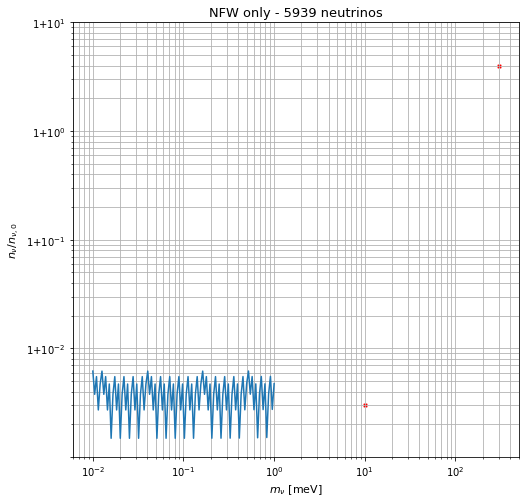

Max value: 1.006201166098679 0.00898393898302392


In [2]:
from shared.preface import *
import shared.functions as fct
import shared.my_units as my
import shared.control_center as CC

# Load data, which function uses.
u_all = fct.load_u_sim()

def number_density_1_mass(m_eV, average=False):

    n_nus = np.zeros(len(m_eV))
    n_eff = np.zeros(len(m_eV))
    for i, m_eV in enumerate(m_eV):

        # Convert to momenta.
        p_all, y_all = fct.u_to_p_eV(u_all, m_eV)
        
        # Select correct momentum range.
        indices = np.where((CC.LOWER <= y_all[:,0]) & (y_all[:,0] <= CC.UPPER))
        p = p_all[indices]

        if average and m_eV.value >= 0.1:
            # Calculate number density, values are averaged for z in [3.5, 4].
            idx = np.array(np.where(CC.ZEDS >= 3.5)).flatten()

            temp = np.zeros(len(idx))
            for j,k in enumerate(idx):
                val = fct.number_density(p[:,0], p[:,k]).value
                temp[j] = val

            n_nus[i] = np.mean(temp)

        else:
            n_nus[i] = fct.number_density(p[:,0], p[:,-1]).value

        # Amount of neutrinos after selection.
        n_eff[i] = len(p)

    np.save('neutrino_data/number_densities.npy', n_nus)

    return int(np.mean(n_eff))


# 10 to 300 meV like in the paper
# mass_range_eV = np.array([0.01, 0.05, 0.1, 0.3])*unit.eV
mLow, mUpp = CC.NU_MASS_LOW.value, CC.NU_MASS_UPP.value
mass_range_eV = np.geomspace(mLow, mUpp, 100)*unit.eV

nr_nu_eff = number_density_1_mass(mass_range_eV, average=True)
n_nus = np.load('neutrino_data/number_densities.npy')/CC.N0

# Plotting:
fig, ax = plt.subplots(1,1, figsize=(8,8))

ax.plot(mass_range_eV*1e3, (n_nus-1))
x_ends = [1e1, 3*1e2]
y_ends = [3*1e-3, 4]
ax.scatter(x_ends, y_ends, s=12, marker='x', c='r')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title(f'NFW only - {nr_nu_eff} neutrinos')
ax.set_xlabel(r'$m_{\nu}$ [meV]')
ax.set_ylabel(r'$n_{\nu} / n_{\nu, 0}$')
ax.set_ylim(1e-3, 1e1)
# ax.set_xlim(1e-5,1e-3)
plt.grid(True, which="both", ls="-")

ax.yaxis.set_major_formatter(ticker.FuncFormatter(fct.y_fmt))

plt.savefig(f'check_plots/densities_{CC.NR_OF_NEUTRINOS}_nus.pdf')
plt.show()

print('Max value:', np.max(n_nus), np.max(n_nus/CC.N0))

## Fermi-Dirac shape

In [ ]:
# Load velocities of sim.
u_all = fct.load_u_sim()

In [ ]:
# Position of earth w.r.t Milky Way NFW halo center.
x1, x2, x3 = 8.5, 0., 0.
x0 = np.array([x1, x2, x3])

fig, axs = plt.subplots(2,2, figsize=(12,10))
fig.suptitle(
    'Mometum Phase-Space distributions' 
    '\n'
    f'({CC.NR_OF_NEUTRINOS} neutrinos)',
    fontsize=18)

masses = np.array([0.01, 0.05, 0.1, 0.3])*unit.eV
for j, m_eV in enumerate(masses):

    k = j

    # Convert to momenta.
    p_all, y_all = fct.u_to_p_eV(u_all, m_eV)

    # Sort.
    order = p_all[:,0].argsort()
    p_sort, y_sort = p_all[order], y_all[order]

    # Select initial and final momenta.
    p0, p1 = p_sort[:,0], p_sort[:,-1]
    y0, y1 = y_sort[:,0], y_sort[:,-1]

    #NOTE: Each velocity has a batch of neutrinos, so average each batch.
    p1_blocks = p1.reshape((CC.Vs, CC.PHIs*CC.THETAs))
    p1_smooth = np.min(p1_blocks, axis=1)

    # Select correct momentum range.
    y0_blocks = y0.reshape((CC.Vs, CC.PHIs*CC.THETAs))
    y0_smooth = y0_blocks[:,0]
    indices = np.where((CC.LOWER <= y0_smooth) & (y0_smooth <= CC.UPPER))
    p = p1_smooth[indices]
    y = y0_smooth[indices]

    # Fermi Dirac of the smoothed (and in correct range) final momenta.
    FDvals = fct.Fermi_Dirac(p)

    i = 0
    if j in (2,3):
        i = 1
        j -= 2
    
    # Escape momentum.
    p_esc_eV, y_esc = fct.escape_momentum(x0, 0., my.rho0_NFW, my.Mvir_NFW, m_eV)
    axs[i,j].axvline(y_esc, c='k', ls='-.', label='y_esc')

    # Original Fermi-Dirac distr.
    pOG = np.geomspace(CC.LOWER*my.T_nu_eV, CC.UPPER*my.T_nu_eV, len(FDvals))
    FDvalsOG = fct.Fermi_Dirac(pOG)
    yOG = (pOG/my.T_nu_eV).value

    axs[i,j].loglog(yOG, FDvals, label='Simulation', c='red', alpha=0.6)
    axs[i,j].loglog(yOG, FDvalsOG, label='Fermi-Dirac', c='blue')
    axs[i,j].set_title(f'{m_eV.value} eV')
    axs[i,j].set_ylabel('FD(p)')
    axs[i,j].set_xlabel(r'$y = p / T_{\nu,0}$')
    axs[i,j].legend(loc='lower left')


plt.savefig('check_plots/fermi_dirac_distr.pdf')
plt.show()

## Initial and final momenta.

In [ ]:
# Load velocities of sim.
u_all = fct.load_u_sim()

# Position of earth w.r.t Milky Way NFW halo center.
x1, x2, x3 = 8.5, 0., 0.
x0 = np.array([x1, x2, x3])

fig, axs = plt.subplots(2,2, figsize=(12,10))
fig.suptitle(
    'Initial and final momenta (sorted)' 
    '\n'
    f'({CC.NR_OF_NEUTRINOS} neutrinos)',
    fontsize=18)

masses = np.array([0.01, 0.05, 0.1, 0.3])*unit.eV
for j, m_eV in enumerate(masses):

    # Convert to momenta.
    p_all, y_all = fct.u_to_p_eV(u_all, m_eV)

    # Select correct momentum range.
    indices = np.where((CC.LOWER <= y_all[:,0]) & (y_all[:,0] <= CC.UPPER))
    p = p_all[indices]
    y = y_all[indices]

    p0, p1 = p[:,0], p[:,-1]
    y0, y1 = y[:,0], y[:,-1]

    # Sort.
    order = p0.argsort()
    p0_sort, p1_sort = p0[order], p1[order]
    y0_sort, y1_sort = y0[order], y1[order]

    i = 0
    if j in (2,3):
        i = 1
        j -= 2
    
    # Escape momentum.
    p_esc_eV, y_esc = fct.escape_momentum(x0, 0., my.rho0_NFW, my.Mvir_NFW, m_eV)
    axs[i,j].axhline(y_esc, c='k', ls='-.', label='y_esc')

    # Average momenta below escape momentum.

    x = np.arange(len(y0_sort))
    axs[i,j].semilogy(x, y0_sort, label='initial momentum')
    axs[i,j].semilogy(x, y1_sort, label='final momentum', alpha=0.6)
    axs[i,j].set_title(f'{m_eV.value} eV')
    axs[i,j].set_xlabel('Neutrino number')
    axs[i,j].set_ylabel(r'$p / T_{\nu,0}$')
    axs[i,j].legend(loc='lower right')

plt.show()